In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyts.classification import TimeSeriesForest
from pyts.classification import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate

In [16]:
df = pd.read_csv('right_arm_light.csv', header=None)
df.columns = ['Board', 'Time', 'Sensor 0', 'Sensor 1', 'Sensor 2', 'Button']
df["Row"] = df.index
board0 = df[df['Board'] == 'Board0']
board1 = df[df['Board'] == 'Board1']
board1['Row'] = board1['Row'] - 1
dfc = pd.merge(board0, board1, on='Row', suffixes=('_0', '_1'))

/tmp/ipykernel_18957/1636256176.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  board1['Row'] = board1['Row'] - 1


In [3]:
dfc

,Board_0,Time_0,Sensor 0_0,Sensor 1_0,Sensor 2_0,Button_0,Row,Board_1,Time_1,Sensor 0_1,Sensor 1_1,Sensor 2_1,Button_1
0,Board0,5567749.0,1.527539,1.502563,1.517871,0.0,0,Board1,5562607.0,1.427637,1.517065,1.474365,0.0
1,Board0,5568784.0,1.517871,1.500147,1.523511,0.0,2,Board1,5563640.0,1.444556,1.515454,1.475977,0.0
2,Board0,5569803.0,1.521094,1.496924,1.518677,0.0,4,Board1,5564658.0,1.474365,1.506592,1.463892,0.0
3,Board0,5570819.0,1.513037,1.487256,1.521899,0.0,6,Board1,5565675.0,1.502563,1.496924,1.502563,0.0
4,Board0,6136806.0,1.527539,1.509009,1.518677,0.0,8,Board1,6140864.0,1.469531,1.548486,1.477588,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
458,Board0,47238695.0,1.522705,1.499341,1.538818,0.0,916,Board1,47243637.0,1.464697,1.525122,1.473559,0.0
459,Board0,47339448.0,1.533984,1.510620,1.551709,0.0,918,Board1,47343375.0,1.464697,1.511426,1.460669,0.0
460,Board0,47439156.0,1.533179,1.506592,1.554932,0.0,920,Board1,47447226.0,1.496118,1.501758,1.516260,0.0
461,Board0,47543965.0,1.522705,1.505786,1.461475,0.0,922,Board1,47541868.0,1.488867,1.513037,1.483227,0.0


In [17]:
X = dfc[['Sensor 0_0', 'Sensor 1_0', 'Sensor 2_0', 'Sensor 0_1', 'Sensor 1_1', 'Sensor 2_1']].to_numpy()
y = dfc['Button_0'].to_numpy()
X.shape, y.shape

((436, 6), (436,))

CV 0: 0.632183908045977
CV 1: 0.6551724137931034
CV 2: 0.6091954022988506
CV 3: 0.6896551724137931
CV 4: 0.7471264367816092
Average score: 0.7025862068965517


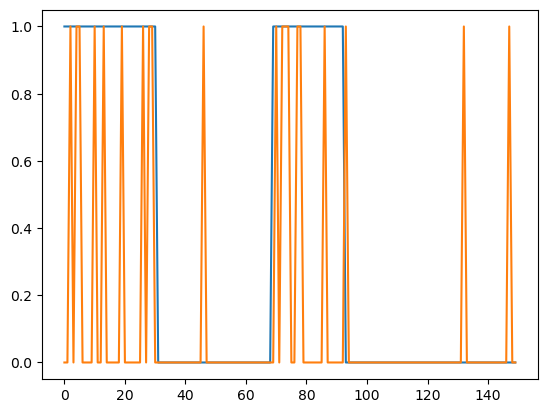

In [18]:
clf = TimeSeriesForest(
    n_estimators=50, criterion='entropy', max_depth=1, n_jobs=-1)

# setup cross validation
cv_num = 5
cv_sz = int(len(X) / cv_num)

avg_score = None

for i in range(cv_num):
    X_test = X[cv_sz * i:cv_sz * (i + 1)]
    y_test = y[cv_sz * i:cv_sz * (i + 1)]
    X_train = np.concatenate((X[:cv_sz * i], X[cv_sz * (i + 1):]))
    y_train = np.concatenate((y[:cv_sz * i], y[cv_sz * (i + 1):]))
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print(f"CV {i}: {score}")
    if avg_score is None:
        avg_score = score
    else:
        avg_score = (avg_score + score) / 2

print(f"Average score: {avg_score}")
clf.fit(X, y)

tx = X[-150:]
ty = y[-150:]

pred = clf.predict(tx)
# pred = np.array([1 if pred[i:i+3].sum()/3 > 0 else 0 for i in range(len(pred) - 3)])


plt.plot(ty)
plt.plot(pred)

In [19]:
import pickle

clf.fit(X, y)

with open('model_light.pkl', 'wb') as f:
    pickle.dump(clf, f)

CV 0: 0.7717391304347826
CV 1: 0.8913043478260869
CV 2: 0.8369565217391305
CV 3: 0.8586956521739131
CV 4: 0.7282608695652174
Average score: 0.7873641304347827


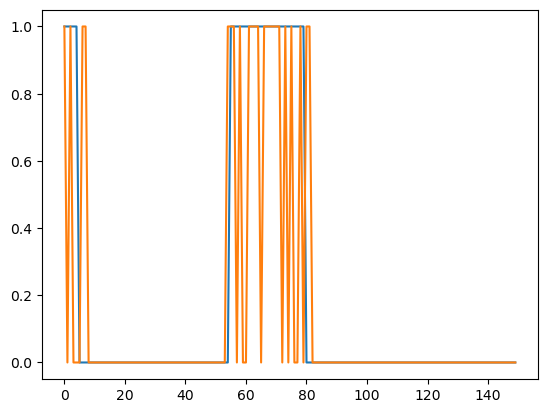

In [13]:
clf = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)

# setup cross validation
cv_num = 5
cv_sz = int(len(X) / cv_num)

avg_score = None

for i in range(cv_num):
    X_test = X[cv_sz * i:cv_sz * (i + 1)]
    y_test = y[cv_sz * i:cv_sz * (i + 1)]
    X_train = np.concatenate((X[:cv_sz * i], X[cv_sz * (i + 1):]))
    y_train = np.concatenate((y[:cv_sz * i], y[cv_sz * (i + 1):]))
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print(f"CV {i}: {score}")
    if avg_score is None:
        avg_score = score
    else:
        avg_score = (avg_score + score) / 2

print(f"Average score: {avg_score}")
clf.fit(X, y)

tx = X[-150:]
ty = y[-150:]

pred = clf.predict(tx)
# pred = np.array([1 if pred[i:i+3].sum()/3 > 0 else 0 for i in range(len(pred) - 3)])


plt.plot(ty)
plt.plot(pred)


0.972576318098706


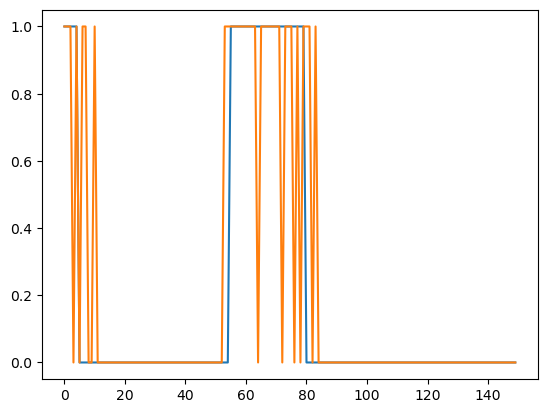

In [14]:
clf=RandomForestClassifier(random_state=42, class_weight="balanced", criterion='gini', max_depth=3, max_features='auto', n_estimators=200)

k_fold = StratifiedKFold(n_splits=cv_num, shuffle=True, random_state=0)

output = cross_validate(clf, X, y, cv=k_fold, scoring='roc_auc', return_estimator=True)
print(output['test_score'].mean())
clf.fit(X, y)

tx = X[-150:]
ty = y[-150:]

pred = clf.predict(tx)
# pred = np.array([1 if pred[i:i+3].sum()/3 > 0 else 0 for i in range(len(pred) - 3)])


plt.plot(ty)
plt.plot(pred)


In [15]:
a = np.array([0,1,2])
b = np.array([1,1,2])
np.vstack([a,b]).shape

(2, 3)